In [1]:
from maliboo import BayesianOptimization, UtilityFunction
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

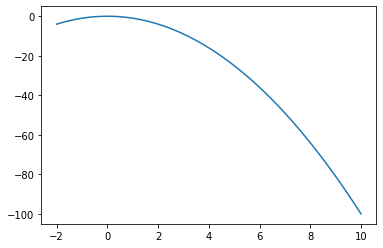

In [2]:
def target(x):
    #return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
    return - x**2

x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [9]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# # UCB
# # Initialize optimizer
# optimizer = BayesianOptimization(target, {'x': (-2, 10)},
#                                  random_state=272242)
# # First rounds of optimization
# optimizer.maximize(init_points=3, n_iter=1, kappa=5)
# for style in ('classic', 'dark'):  # ('transparent', 'classic', 'dark')
#     plot_gp(optimizer, x, y, show_minimized=True, style=style)

# EB
# Initialize optimizer again
optimizer = BayesianOptimization(target, {'x': (-5, 5)}, 
                                 random_state=2722,barrier_func={'constraint1': lambda x:  x**2 - 36},debug=True)
# Other rounds of optimization
optimizer.maximize(init_points=5, n_iter=10,acq='eb',acq_info={'static_lambda':True})


Initializing TargetSpace with bounds: {'x': (-5, 5)}
initialize_dataset(): dataset is None
TargetSpace initialization completed
BayesianOptimization initialization completed
Starting maximize()
|   iter    |  target   |     x     |
-------------------------------------
_prime_queue(): initializing 5 random points
Uniform randomly sampled point: value [[-2.54231509]]
Uniform randomly sampled point: value [[-3.89252552]]
Uniform randomly sampled point: value [[-0.63250282]]
Uniform randomly sampled point: value [[-2.70457049]]
Uniform randomly sampled point: value [[-4.25680406]]
Initializing UtilityFunction of kind 'eb' with acq_info = {'static_lambda': True}
Setting 'static_lambda' field of acq_info to 'static_lambda' member
UtilityFunction initialization completed
Initializing StoppingCriterion with stop_crit_info = {}
StoppingCriterion initialization completed
++++++++++++++++++++++++
Starting optimization loop
New iteration: selected point from queue, index None, value {'x': -2.5423